In [2]:
def mutual_information(X, Y, xbins=10, ybins=10):
  """
  Return the mutual information between X and Y. X is a matrix which is N_neurons x N_timepoints, and Y is a vector which is N_timepoints long.

  The way this works: It computes a histogram (normalized to a probability distribution) of Y with ybins number of bins (default 10).
  Likewise, it histograms each row of X (with xbins bins). It then treats these as categorical probability distributions
  and computes the KL divergence beween the product of thesee distributiosn and the joint distribution.

  Example:
  
      MI_stimulus = mutual_information(dat['sresp'], dat['istim'])
  
  This computes the mutual information between neural firing and the stimulus angle.
  """ 
  import warnings
  warnings.filterwarnings('ignore')
  MI = np.zeros(X.shape[0])
  P_Y, _ = np.histogram(Y, density=True, bins=ybins)
  for x_n in range(X.shape[0]):
    P_X, _ = np.histogram(X[x_n,:], density=True, bins=xbins)
    P_XY, _, _ = np.histogram2d(X[x_n,:], Y, density=True, bins=[xbins,ybins])
    P_XP_Y = np.outer(P_X, P_Y)

    summands = P_XY * np.log2(P_XY / P_XP_Y, out=np.zeros_like(P_XY), where=P_XP_Y!=0)
    MI[x_n] = np.sum(summands, where=~np.isnan(summands))
  
  return MI

def plot_mi_sorted_neurons(dat1, n_start = 0, n_stop = 100, n_step = 1, ydel = 2e1):
    from scipy.stats import zscore
    Z1 = zscore(dat1['sresp'], axis = 1)
    M1 = mutual_information(Z1, dat1['istim'])
    yupperlim = 5
    from matplotlib import pyplot as plt
    from scipy.signal import butter, filtfilt
    from scipy.stats import zscore
    b,a = butter(4, [0.1], 'lowpass')
    fig = plt.figure(figsize = (14,10))
    pidx = np.argsort(-M1) # negative M -> sorts from highest to lowest
    alpha = 0.6
    col = [0,0,0,alpha]
    idx = np.argsort(dat1['istim'])
    t = np.linspace(0,2*np.pi,len(idx))
    plt.subplot(1,3,3)
#     plt.title('Highest MI Neurons\n 0 - 100',fontsize = 16)
#     plt.title('Highest MI Neurons\n %05d - %05d' %d(n_start, n_stop),fontsize = 16)
    plt.title(f'Highest MI Neurons\n {n_start:=05d} - {n_stop:=05d}',fontsize = 16)
    Z1_sum1 = np.zeros((Z1.shape[1]))
    range_idx = np.arange(n_start,n_stop,n_step)
    max_idx = np.zeros_like(range_idx)
    for k , k2 in enumerate(range_idx):
        max_idx[k] = np.argmax(filtfilt(b,a,Z1[pidx[k2],idx]))
        Z1_sum1 = Z1_sum1 + Z1[pidx[k2],idx]
        Z1_sum1 = filtfilt(b,a,Z1_sum1)
    range_idx = range_idx[np.argsort(max_idx)]
    for k , k2 in enumerate(range_idx):
        plt.plot(t,Z1[pidx[k2],idx] + k*ydel, color = col)
    plt.plot(t,(Z1_sum1)*40/((n_stop - n_start)/n_step) + (k+1.5)*ydel, color = [0.5,0,0])
    plt.ylim([0,(n_stop - n_start + yupperlim)*ydel/n_step])
    plt.xlim([0,2*np.pi])
    plt.xticks(ticks = np.array([0,0.5,1,1.5,2])*np.pi, labels = ['0','$\\frac{\pi}{2}$','$\pi$', '$\\frac{\pi}{2}$', '$2\pi$'],fontsize = 14)
    plt.yticks([])
    plt.xlabel('Orientation Angle', fontsize = 14)
    plt.ylabel('Sorted Neurons', fontsize = 14)
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['left'].set_visible(False)
    plt.gca().spines['top'].set_visible(False)

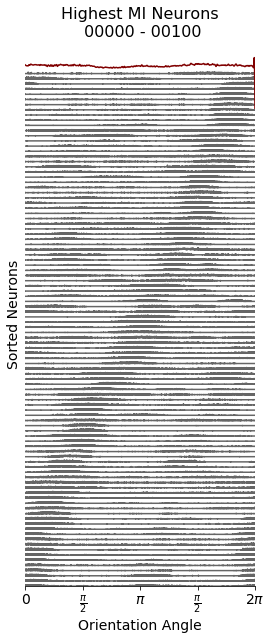

In [23]:
# for loop:
plot_mi_sorted_neurons(dat, n_start = 0, n_stop = 100) #change ydel if lines aren't "thick" enough
# save figure